In [40]:
# import libraries
import sqlite3 as sl
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.figure_factory as ff

In [15]:
def get_db_connn(path_to_db):
    conn = sl.connect(path_to_db)
    return conn


def get_table_names(conn):
    query = """
            select name from sqlite_master where type='table';
            """
    res = conn.execute(query).fetchall()
    table_names = [r[0] for r in res]
    return table_names


def get_table_column_names(conn, table_name):
    query = f"""
            pragma table_info({table_name})
            """
    res = conn.execute(query).fetchall()
    col_names = [r[1] for r in res]
    return col_names


def load_table_as_df(conn, table_name, to_display=True):
    query = f"""
            select * from {table_name}
            """
    df = pd.read_sql(query, conn)
    if to_display:
        display(df.head())
    return df

In [16]:
db_path = '../data/northWind.sqlite'
conn = get_db_connn(db_path)

# get the table names first of all
print(get_table_names(conn))

['Employee', 'Category', 'Customer', 'Shipper', 'Supplier', 'Order', 'Product', 'OrderDetail', 'CustomerCustomerDemo', 'CustomerDemographic', 'Region', 'Territory', 'EmployeeTerritory']



### Order table

In [20]:
query = """ pragma table_info('Order'); """
res = conn.execute(query).fetchall()
col_names = [r[1] for r in res]
print(col_names)

['Id', 'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate', 'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress', 'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry']


In [28]:
orders_q = """SELECT Id, EmployeeId FROM 'Order'; """
orders_df = pd.read_sql(orders_q, conn)
print(orders_df.info())
orders_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Id          830 non-null    int64
 1   EmployeeId  830 non-null    int64
dtypes: int64(2)
memory usage: 13.1 KB
None


,Id,EmployeeId
0,10248,5
1,10249,6
2,10250,4
3,10251,3
4,10252,4


### OrderDetail table

In [17]:
print(get_table_column_names(conn, 'OrderDetail'))

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']


In [29]:
#get the data for order quantities and discounts
orderdetails_q = """select * from OrderDetail;"""

orderdetails_df = pd.read_sql(orderdetails_q, conn)
print(orderdetails_df.info())
print(orderdetails_df.describe())
orderdetails_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         2155 non-null   object 
 1   OrderId    2155 non-null   int64  
 2   ProductId  2155 non-null   int64  
 3   UnitPrice  2155 non-null   float64
 4   Quantity   2155 non-null   int64  
 5   Discount   2155 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB
None
            OrderId    ProductId    UnitPrice     Quantity     Discount
count   2155.000000  2155.000000  2155.000000  2155.000000  2155.000000
mean   10659.375870    40.793039    26.218520    23.812993     0.056167
std      241.378032    22.159019    29.827418    19.022047     0.083450
min    10248.000000     1.000000     2.000000     1.000000     0.000000
25%    10451.000000    22.000000    12.000000    10.000000     0.000000
50%    10657.000000    41.000000    18.400000    20.000000     0.000000
7

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [48]:
print(np.sort(orderdetails_df['UnitPrice'].unique()))

[  2.     2.5    3.6    4.5    4.8    5.6    5.9    6.     6.2    7.
   7.2    7.3    7.45   7.6    7.7    7.75   8.     9.     9.2    9.5
   9.6    9.65   9.8   10.    10.2   10.4   10.6   11.2   12.    12.4
  12.5   12.75  13.    13.25  13.6   13.9   14.    14.4   14.7   15.
  15.2   15.5   15.6   16.    16.25  16.8   17.    17.2   17.45  17.6
  18.    18.4   18.6   19.    19.2   19.45  19.5   20.    20.7   20.8
  21.    21.05  21.35  21.5   22.    22.8   23.25  24.    24.8   24.9
  25.    25.6   25.89  26.    26.2   26.6   27.2   27.8   28.5   28.8
  30.    30.4   31.    31.2   31.23  32.    32.8   33.25  34.    34.8
  35.1   36.    36.4   36.8   38.    39.    39.4   40.    42.4   43.9
  44.    45.6   46.    49.3   50.    53.    55.    62.5   64.8   77.6
  81.    97.    99.   123.79 210.8  263.5 ]


Text(0, 0.5, 'Quantity')

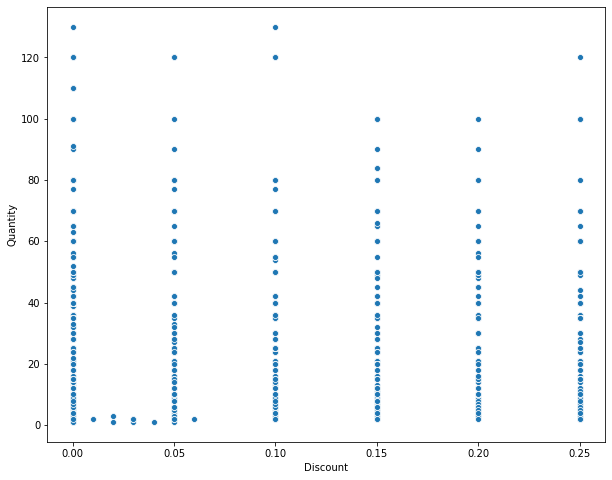

In [41]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="Discount", 
                y="Quantity",
                data=orderdetails_df)
plt.xlabel("Discount")
plt.ylabel("Quantity")

In [10]:
print(np.sort(orderdetails_df['Discount'].unique()))

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.15 0.2  0.25]


There are a few discounts between zero and 5%, and 1 between 5% and 10%.
Suggest we use the follow discount categories to do **Order** group by: 0%, 5% or less, between 5 %-10%, 15%, 20%, 25%

Could also simplify:
**control**: No Discount for Product
**treatment**: Some Discount (no matter what amount) for Product

In [36]:
#create a new column, has_discount, containing 0 or 1
orderdetails_df['has_discount'] = orderdetails_df.apply(lambda row: 1 if row.Discount> 0.0 else 0, axis=1)
orderdetails_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,has_discount
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


In [39]:
# Cool...now we know which products were discounted on not
# we are really only interested in Quantity and has_discount so drop what we do not need.
quantity_discount_df = orderdetails_df.drop(columns=['Id', 'OrderId', 'UnitPrice', 'Discount'])
quantity_discount_df.head()

,ProductId,Quantity,has_discount
0,11,12,0
1,42,10,0
2,72,5,0
3,14,9,0
4,51,40,0


In [49]:
discount_quantity = quantity_discount_df.loc[quantity_discount_df['has_discount']==1, 'Quantity']
nodiscount_quantity = quantity_discount_df.loc[quantity_discount_df['has_discount']==0, 'Quantity']

anova_result = scs.f_oneway(discount_quantity, nodiscount_quantity)
print(anova_result)
anova_result.pvalue

F_onewayResult(statistic=41.971781088386834, pvalue=1.1440924523215329e-10)


1.1440924523215329e-10

In [51]:
multicompare_discount = MultiComparison(quantity_discount_df['Quantity'], quantity_discount_df['has_discount'])

In [52]:
tukey_hsd = multicompare_discount.tukeyhsd(alpha=.05)

In [53]:
simple_table = tukey_hsd.summary()
simple_table

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,5.3945,0.001,3.7616,7.0274,True


In [13]:
#get the data for order ids (one id is one order) joined with employee territory

orders_w_region_q = """
                        SELECT 'Order'.Id, 'Order'.EmployeeId, Territory.RegionId 
                        FROM 'Order'
                        INNER JOIN EmployeeTerritory ON 'Order'.EmployeeId=EmployeeTerritory.EmployeeId
                        INNER JOIN Territory ON EmployeeTerritory.TerritoryId = Territory.Id;
                        """

orders_regions_df = pd.read_sql(orders_w_region_q, conn)
print(orders_regions_df.shape)
orders_regions_df.head()

(3960, 3)


,Id,EmployeeId,RegionId
0,10258,1,1
1,10270,1,1
2,10275,1,1
3,10285,1,1
4,10292,1,1


In [44]:
print(get_table_column_names(conn, 'Employee'))

['Id', 'LastName', 'FirstName', 'Title', 'TitleOfCourtesy', 'BirthDate', 'HireDate', 'Address', 'City', 'Region', 'PostalCode', 'Country', 'HomePhone', 'Extension', 'Photo', 'Notes', 'ReportsTo', 'PhotoPath']


In [45]:
print(get_table_column_names(conn, 'EmployeeTerritory'))

['Id', 'EmployeeId', 'TerritoryId']


In [46]:
print(get_table_column_names(conn, 'Territory'))

['Id', 'TerritoryDescription', 'RegionId']


In [54]:
q_emp_region = """
            SELECT EmployeeTerritory.EmployeeId, Territory.RegionId 
            FROM EmployeeTerritory
            INNER JOIN Territory ON EmployeeTerritory.TerritoryId=Territory.Id;
            """

emp_region_df = pd.read_sql(q_emp_region, conn)
print(emp_reg_df.shape)
emp_region_df.head(49)

(49, 2)


,EmployeeId,RegionId
0,1,1
1,1,1
2,2,1
3,2,1
4,2,1
5,2,1
6,2,1
7,2,1
8,2,1
9,3,4


# Question 1: Is there a difference in quantity of products sold by discount rate? 

In [ ]:
# obtain necessary data

# Question 2: Is there a difference in anyhing to do with territories or regions? 

In [1]:
# obtain necessary data

# Question 3: {You decide}